In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

#TODO: this should be 224 if we want to use mobilenet
target_shape = (200, 200)

In [3]:
def normalize(image):
    """normalize pixels to be between 0 and 1 (could also have been -1 and 1, but since resnet was originally trained on 0,1, we havve to stick with that)"""

	# convert from integers to floats
    image_norm = image.astype('float32')
	# normalize to range -1 and 1
    image_norm = (image_norm - 127.5) / 127.5
    
    
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image_norm = [[(channel - mean)/std for channel in row]  for row in image_norm]
    

	# return normalized images
    return image_norm

In [3]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [16]:
# Load images into arrays
import pathlib

#specify a maximum how many pair that can be made pr class (value is for both positive and negative pairs )

def load_images(path):
    img_array_data = []
    data_dir = pathlib.Path(path)
    image_count = len(list(data_dir.glob('*/*.jpg')) + list(data_dir.glob('*/*.jpeg')) + list(data_dir.glob('*/*.png')))
    folders = [x for x in data_dir.iterdir() if x.is_dir()]
    for i, folder in enumerate(folders):
        img_array_data.append([])

        for j, img in enumerate(folder.iterdir()):
        
            img_array_data[i].append(img)
            
    return img_array_data


def load_images_v2(path):
    data_dir = os.listdir(path)
    img_array_data = []
    
    folders = data_dir#[x for x in data_dir]
    for i, dir_path in enumerate(folders):
        img_array_data.append([])

        for j, img in enumerate(os.listdir(path + "/"+dir_path)):
        
            img_array_data[i].append(path + "/"+dir_path+"/"+img)
            
    return img_array_data



import math

#test_data = load_images("./data/tiered_imagenet/test")

#val_data = load_images("./data/tiered_imagenet/val")

# -1 means equals amount of pairs pr. available class
def get_anchor_and_positives(images, max_pairs, max_pairs_per_class=-1):
    anchor_images, positive_images = [],  []
    should_break = False
    should_terminate = False
    if(max_pairs_per_class == -1):
        max_pairs_per_class = math.floor(max_pairs/len(images) +1)
        
    
    for i, array in enumerate(images):
        if(should_terminate):
            print("Terminating with a class count of: ", i-1)
            break
        for j in range(len(array)-1):
            if(should_break):
                should_break = False
                break
            for k in range(len(array)-1):
                anchor_images.append(images[i][k])
                positive_images.append(images[i][(k+j+1)% len(array)])
                if(len(anchor_images) >= max_pairs): 
                    print("Terminating with a pair count of: ", len(anchor_images))
                    should_terminate = True
                    should_break = True
                    break
                if((j+1)*(k+1) >= max_pairs_per_class):
                    should_break = True
                    break
    return anchor_images, positive_images,

def get_anchor_positives_negatives(images):
    anchor_images, positive_images, negative_images = [], [], []
   
    
    for i, array in enumerate(images):
        
        for j in range(len(array)-1):
            for k in range(len(array)-1):
                anchor_images.append(images[i][k])
                positive_images.append(images[i][(k+j+1)% len(array)])
                negative_images.append(images[(i + 1)%len(images)][k % len(images[(i + 1)%len(images)])])
    return anchor_images, positive_images, negative_images


#anchor_images, positive_images = get_anchor_n_positives(test_data)
#anchor_images, positive_images = get_anchor_n_positives(val_data)



#print("train samples: ", len(train_data))
#print("validation samples: ",len(val_data))
#print("test samples: ", len(test_data))

#unison_shuffled_copies(train_data, train_labels)
#unison_shuffled_copies(test_data, test_labels)
#unison_shuffled_copies(val_data, val_labels)

In [17]:

data = []
data.extend(load_images_v2("./data/tiered_imagenet/train"))
data.extend(load_images_v2("./data/tiered_imagenet/val"))
print("Maximum Available Classes: " + str(len(data)))
anchor_images, positive_images = get_anchor_and_positives(data, 10000)
pair_count = len(anchor_images)
print(pair_count)




Maximum Available Classes: 448
Terminating with a pair count of:  10000
Terminating with a class count of:  434
10000


In [19]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(len(list(dataset)) * 0.8))
val_and_test = dataset.skip(round(len(list(dataset)) * 0.8))
val_dataset = val_and_test.take(round(len(list(val_and_test)) * 0.5))
test_dataset = val_and_test.skip(round(len(list(val_and_test)) * 0.5))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

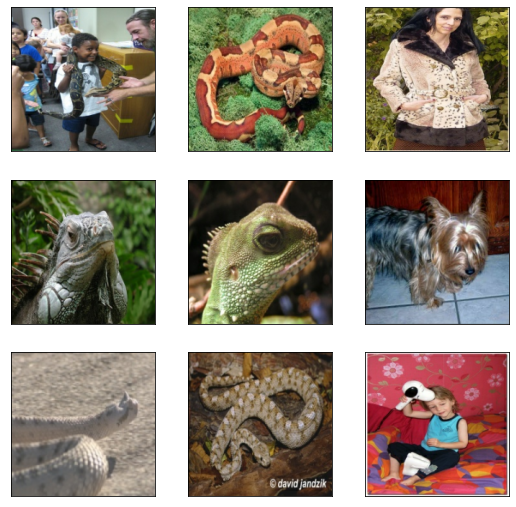

In [20]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [21]:
#TODO: this should be mobilenet

base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

#TODO: consider using anohter flattening layer
flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [22]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [23]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """
    
    #why are we using a margin of 0.5? The distance calculation is using L2 ie. Euclidean distance, and with euclidian distances a margin of 0.5 is close to nothing, since the
    #eudclidian distance (for this problem) lies between) 0 and 256 (if one embedding is 1 for all vectors and the other is 0 for all vectors, the distance will be 256, because 1^2 = 1.. repeat for all vectors entries)

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [24]:
siamese_model = SiameseModel(siamese_network, margin=10)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 9.2891 

KeyboardInterrupt: 

In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())